In [20]:
library(tidyverse)
library(repr)
library(tidymodels)
library(dplyr)

players <- read_csv("GamingTimePrediction/Data/players.csv")

filtered_players <- players |>
filter(played_hours > 0 & played_hours <= 25) |>
mutate(experience_encoded = as.numeric(as.factor(experience))) |>
select(experience_encoded, age, played_hours)

filtered_players

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience_encoded,age,played_hours
<dbl>,<dbl>,<dbl>
5,17,3.8
1,21,0.7
4,21,0.1
1,17,0.1
5,23,1.6
2,25,1.5
1,22,0.2
1,17,0.5
4,19,0.6


In [21]:
set.seed(2000)
players_split <- initial_split(filtered_players, prop = 0.80, strata = played_hours)
players_training <- training(players_split)
players_testing <- testing(players_split)

In [22]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |> 
  set_engine("kknn") |> 
  set_mode("regression")

# Define the recipe for preprocessing
players_recipe <- recipe(played_hours ~ age + experience_encoded, data = players_training) |>
  step_scale(all_predictors()) |>  
  step_center(all_predictors())    

knn_spec
players_recipe

K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = 5
  weight_func = rectangular

Computational engine: kknn 




── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 2



── Operations 

• Scaling for: all_predictors()

• Centering for: all_predictors()



In [23]:
players_vfold <- vfold_cv(players_training, v = 5, strata = played_hours)

players_workflow <- workflow() |> 
  add_model(knn_spec) |> 
  add_recipe(players_recipe)

players_vfold
players_workflow


Warning message:
“`optional` is kept for consistency with the underlying class but TRUE values will be ignored.”
Warning message:
“`optional` is kept for consistency with the underlying class but TRUE values will be ignored.”
Warning message:
“`optional` is kept for consistency with the underlying class but TRUE values will be ignored.”
Warning message:
“`optional` is kept for consistency with the underlying class but TRUE values will be ignored.”
Warning message:
“`optional` is kept for consistency with the underlying class but TRUE values will be ignored.”
ERROR while rich displaying an object: Error in (function (..., row.names = NULL, check.rows = FALSE, check.names = TRUE, : arguments imply differing number of rows: 63, 64, 65

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)


══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = 5
  weight_func = rectangular

Computational engine: kknn 


In [24]:
gridvals <- tibble(neighbors = seq(1, 81, by = 10))

knn_spec_tuned <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
  set_engine("kknn") |> 
  set_mode("regression")

players_workflow_tuned <- workflow() |> 
  add_model(knn_spec_tuned) |> 
  add_recipe(players_recipe)

players_results <- tune_grid(
  players_workflow_tuned,
  resamples = players_vfold,  
  grid = gridvals,            
  metrics = metric_set(rmse, rsq) 
)

players_results_metrics <- collect_metrics(players_results)
print(players_results_metrics)


→ A | warning: 81 samples were requested but there were 63 rows in the data. 58 will be used.

There were issues with some computations   A: x1

→ B | error:   ℹ In index: 8.
               Caused by error in `cl[C]`:
               ! only 0's may be mixed with negative subscripts

There were issues with some computations   A: x1
→ C | warning: A correlation computation is required, but `estimate` is constant and has 0
               standard deviation, resulting in a divide by 0 error. `NA` will be returned., A correlation computation is required, but the inputs are size zero or one and
               the standard deviation cannot be computed. `NA` will be returned.

There were issues with some computations   A: x1
→ D | warning: 81 samples were requested but there were 64 rows in the data. 59 will be used.

There were issues with some computations   A: x1
→ E | warning: A correlation computation is required, but the inputs are size zero or one and
               the standard deviatio

# A tibble: 18 × 7
   neighbors .metric .estimator     mean     n  std_err .config             
       <dbl> <chr>   <chr>         <dbl> <int>    <dbl> <chr>               
 1         1 rmse    standard     3.93       3  1.32    Preprocessor1_Model1
 2         1 rsq     standard     0.110      3  0.0516  Preprocessor1_Model1
 3        11 rmse    standard     3.15       3  0.800   Preprocessor1_Model2
 4        11 rsq     standard     0.0645     3  0.0268  Preprocessor1_Model2
 5        21 rmse    standard     3.09       3  0.783   Preprocessor1_Model3
 6        21 rsq     standard     0.0786     3  0.0361  Preprocessor1_Model3
 7        31 rmse    standard     3.02       3  0.774   Preprocessor1_Model4
 8        31 rsq     standard     0.150      3  0.0460  Preprocessor1_Model4
 9        41 rmse    standard     2.97       3  0.812   Preprocessor1_Model5
10        41 rsq     standard     0.145      3  0.0800  Preprocessor1_Model5
11        51 rmse    standard     2.98       3  0.835   P

In [25]:
players_min <- players_results_metrics |>
  filter(.metric == "rmse") |>
  arrange(mean) |>              
  slice(1)                       

players_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
41,rmse,standard,2.966266,3,0.8116085,Preprocessor1_Model5


In [26]:
players_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 41) |> 
  set_engine("kknn") |> 
  set_mode("regression")

players_best_workflow <- workflow() |> 
  add_model(players_best_spec) |> 
  add_recipe(players_recipe)

players_best_fit <- fit(players_best_workflow, data = players_training)

players_predictions <- predict(players_best_fit, new_data = players_testing)

players_summary <- bind_cols(players_testing, players_predictions) |> 
  metrics(truth = played_hours, estimate = .pred)

players_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,5.0158995
rsq,standard,0.1987589
mae,standard,2.0614191


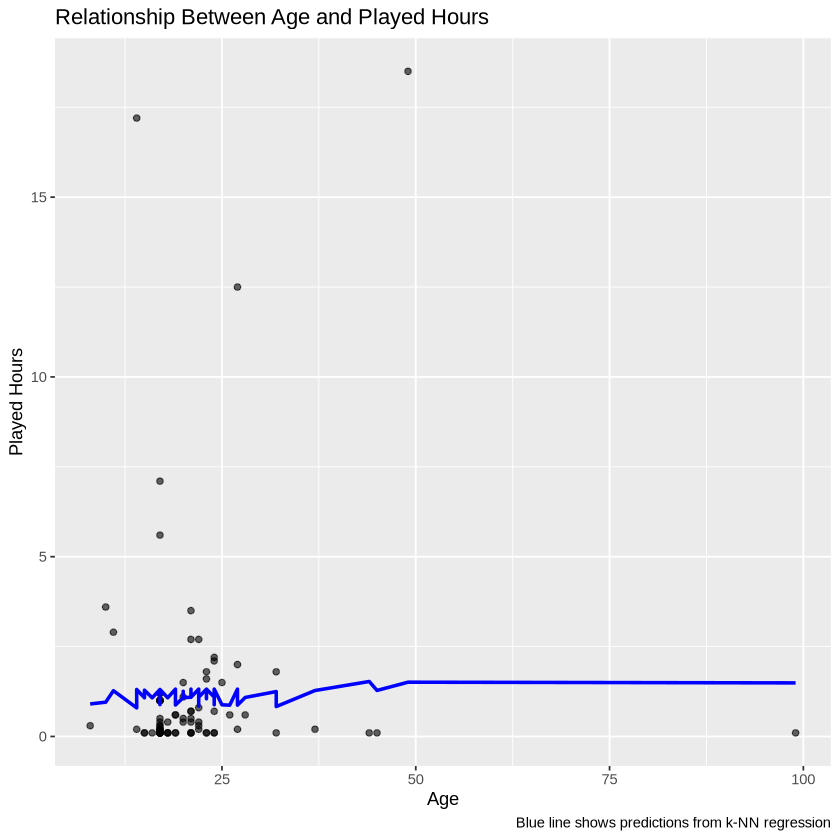

In [31]:
players_preds <- predict(players_best_fit, new_data = players_training) |> 
  bind_cols(players_training)

players_plot <- ggplot(players_preds, aes(x = age, y = played_hours)) +
  geom_point(alpha = 0.6, color = "black") +  
  geom_line(aes(y = .pred), color = "blue", size = 1) + 
  labs(
    title = "Relationship Between Age and Played Hours",
    x = "Age",
    y = "Played Hours",
    caption = "Blue line shows predictions from k-NN regression")

players_plot

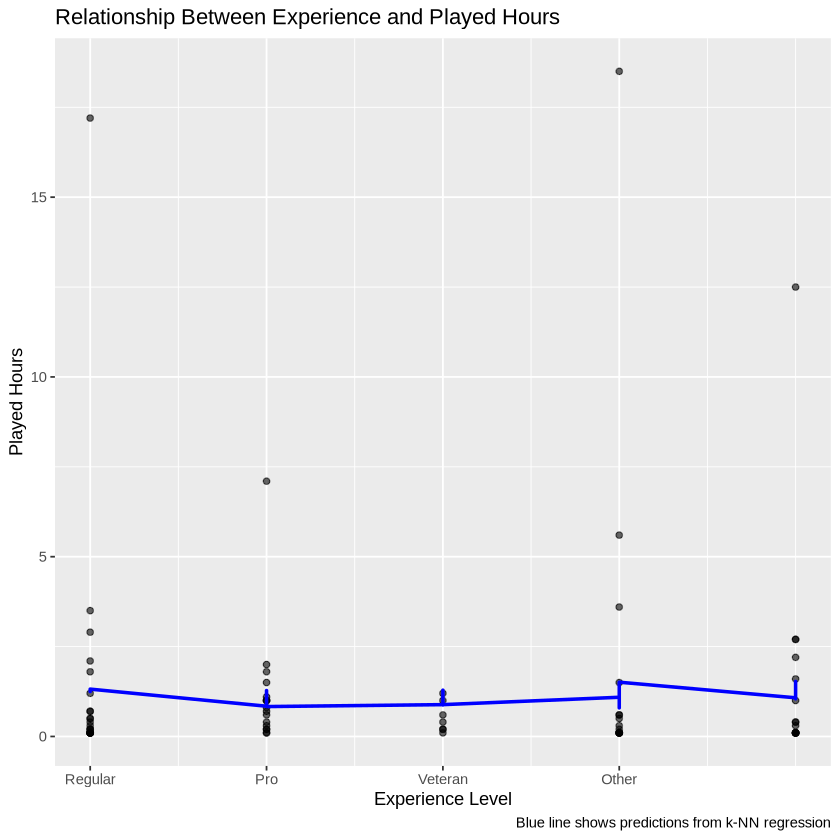

In [32]:
players_preds_experience <- predict(players_best_fit, new_data = players_training) |> 
  bind_cols(players_training)

players_plot_experience <- ggplot(players_preds_experience, aes(x = experience_encoded, y = played_hours)) +
  geom_point(alpha = 0.6, color = "black") +  # Scatterplot of actual data
  geom_line(aes(y = .pred), color = "blue", size = 1) +  # Prediction line
  scale_x_continuous(
    breaks = 0:4, 
    labels = c("Amateur", "Regular", "Pro", "Veteran", "Other")  # Example labels
  ) +
  labs(
    title = "Relationship Between Experience and Played Hours",
    x = "Experience Level",
    y = "Played Hours",
    caption = "Blue line shows predictions from k-NN regression")

players_plot_experience